# Desnormalizando e analisando o Sakila

## Imports

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

plt.rcParams['figure.figsize'] = (20.0, 10.0)

## Questão 1: Qual gênero de filme é alugado por mais tempo? E qual gênero de filme tem o maior preço médio de locação?

Para responder essa pergunta fazemos a seguinte consulta em SQL para obter os dados:

~~~ mysql
SELECT  
	film.film_id,
	film.title,
	film.rental_duration,
	film.rental_rate,
	film_category.category_id,
	category.name
FROM film 
LEFT JOIN film_category ON film.film_id = film_category.film_id
LEFT JOIN category ON film_category.category_id = category.category_id
~~~

Isso nos retorna uma tabela com os filmes, seus títulos, por quanto tempo ficam alugados, o preço de locação e seu gênero. Com isso conseguimos agrupar os filmes por gênero e analisar tanto o preço quanto a duração da locação para descobrirmos o gênero alugado por mais tempo e mais caro. Exportamos a tabela resultante da query para o formato csv e assim é possível usar a biblioteca Pandas para fazer a análise.

In [2]:
film_genres = pd.read_csv('q1.csv')
film_genres.head()

,film_id,title,rental_duration,rental_rate,category_id,name
0,1,ACADEMY DINOSAUR,6,0.99,6,Documentary
1,2,ACE GOLDFINGER,3,4.99,11,Horror
2,3,ADAPTATION HOLES,7,2.99,6,Documentary
3,4,AFFAIR PREJUDICE,5,2.99,11,Horror
4,5,AFRICAN EGG,6,2.99,8,Family


In [3]:
grouped_genres = film_genres.groupby('name').mean()[['rental_duration', 'rental_rate']]
grouped_genres

,rental_duration,rental_rate
name,,
Action,4.953125,2.646250
Animation,4.893939,2.808182
Children,5.033333,2.890000
Classics,5.070175,2.744386
Comedy,4.931034,3.162414
Documentary,4.764706,2.666471
Drama,5.080645,3.022258
Family,5.173913,2.758116
Foreign,5.109589,3.099589


In [4]:
grouped_genres.idxmax()

rental_duration    Travel
rental_rate         Games
dtype: object

Agrupando os filmes por gênero e usando a média como função de agregação para as variáveis que estamos interessados, obtemos a tabela acima. Com a função idxmax() vemos que o gênero que tem maior tempo de locação médio, ou seja, o gênero mais alugado é "Travel" e o gênero com maior preço de locação médio é "Games".

Para fins de comparação, podemos ilustrar os resultados da tabela acima em forma de gráfico.

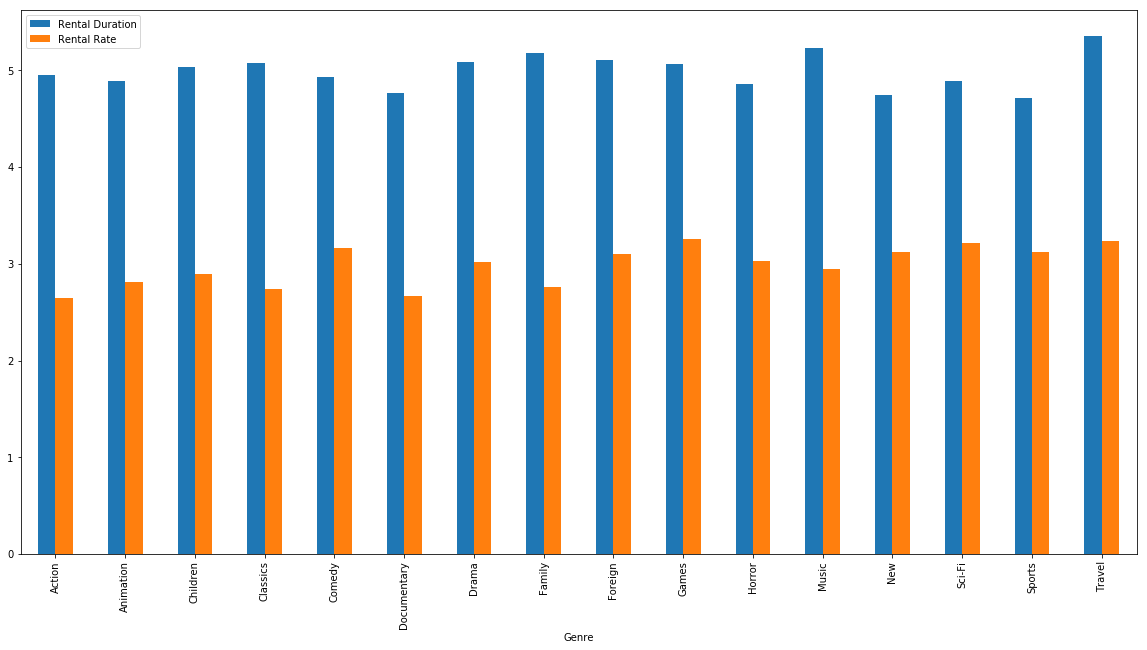

In [5]:
grouped_genres.plot.bar()
plt.xlabel('Genre')
plt.legend(['Rental Duration', 'Rental Rate'])
plt.show()

É possível observar que o gênero do filme parece não ter uma significância muito grande na oscilação das suas variáveis observadas.

## Questão 2: Quais são os filmes mais alugados no Brasil? 

Quando a questão foi idealizada, além de investigar os filmes mais alugados no Brasil, pensei em analisar as variáveis de gênero, língua e classificação indicativa dos filmes alugados por clientes que ainda estão ativos nas suas locadoras. Para obtermos os dados para responder essa questão, a seguinte consulta SQL:

~~~ mysql
SELECT 
	rental.rental_id,
	rental.inventory_id,
	rental.customer_id,
	customer_list.country,
	customer_list.notes,
	inventory.film_id,
	film.title,
	film.language_id,
	language.name,
	film.rating,
	film_category.category_id,
	category.name
FROM rental
LEFT JOIN customer_list ON rental.customer_id = customer_list.ID
LEFT JOIN inventory ON rental.inventory_id = inventory.inventory_id
LEFT JOIN film ON inventory.film_id = film.film_id
LEFT JOIN language ON film.language_id = language.language_id
LEFT JOIN film_category ON film.film_id = film_category.film_id
LEFT JOIN category ON film_category.category_id = category.category_id
WHERE customer_list.notes = 'active'
AND country = 'Brazil'
~~~

Essa extensa consulta não faz nada além de juntar a informação sobre as locações com as informações dos filmes alugados por clientes no Brasil. Para isso usamos a view "customer_list" que já condensa muitas informações sobre os clientes em uma tabela, assim, facilitando a consulta. Novamente, exportamos a tabela resultante para o formato csv e usamos Pandas para realizar a análise dos dados

In [6]:
q2_csv = pd.read_csv('q2.csv')
q2_csv.head()

,rental_id,inventory_id,customer_id,country,notes,film_id,title,language_id,name,rating,category_id,name.1
0,1,367,130,Brazil,active,80,BLANKET BEVERLY,1,English,G,8,Family
1,9,2580,126,Brazil,active,565,MATRIX SNOWMAN,1,English,PG-13,9,Foreign
2,80,2478,314,Brazil,active,543,MADIGAN DORADO,1,English,R,16,Travel
3,82,1388,427,Brazil,active,304,FARGO GANDHI,1,English,G,3,Children
4,104,4281,310,Brazil,active,932,VALLEY PACKER,1,English,G,5,Comedy


Como podemos ver no dataframe acima, a consulta devolve uma tabela que relaciona a locação e seu id com o cliente e o seu país de endereço (no caso, o Brasil), e com o filme e sua língua e categoria através do id do inventário.

In [7]:
len(q2_csv)

748

Olhando primeiramente para a língua dos 748 filmes alugados por clientes no Brasil, podemos ver que todos são em inglês. 

In [8]:
q2_csv['name'].value_counts()

English    748
Name: name, dtype: int64

Analisando a classificação indicativa e gênero dos filmes alugados, é possível observar mais variedade

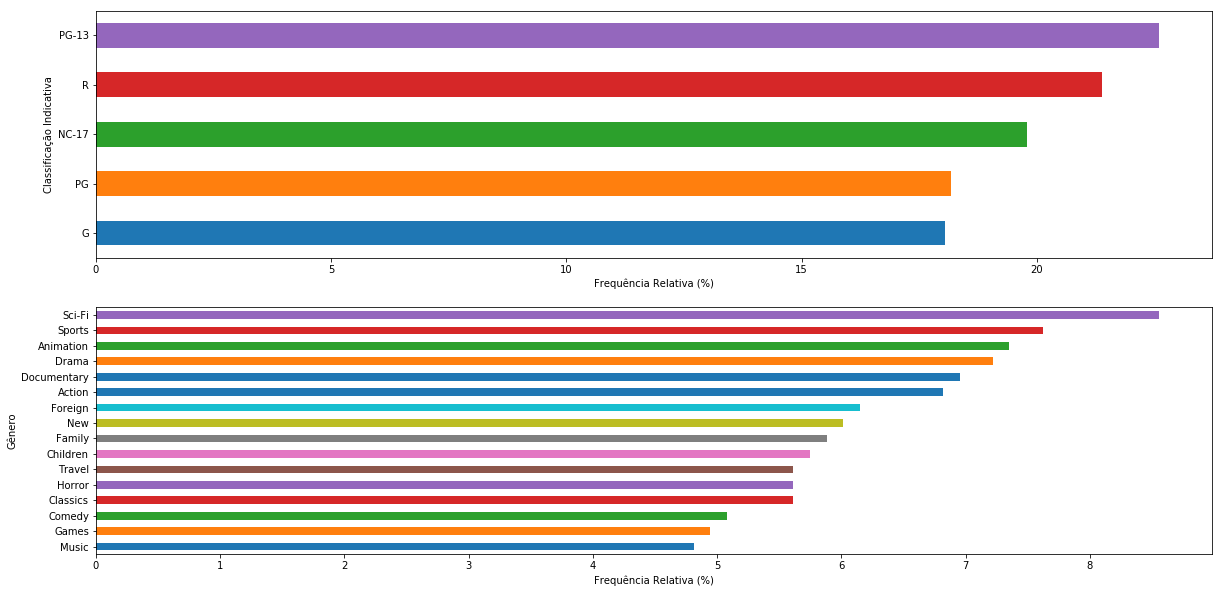

In [9]:
def plotGroup(df, column):
    series = df[column].value_counts() / len(df) * 100
    series.sort_values().plot(kind = 'barh') 

fig = plt.figure()
ax1 = fig.add_subplot(211)
plotGroup(q2_csv, 'rating')
ax2 = fig.add_subplot(212)
plotGroup(q2_csv, 'name.1')

ax1.set_xlabel(u'Frequência Relativa (%)')
ax1.set_ylabel(u'Classificação Indicativa')
ax2.set_xlabel(u'Frequência Relativa (%)')
ax2.set_ylabel(u'Gênero')

plt.show()

O primeiro gráfico acima mostra que em relação à classificação indicativa, aproximadamente um quarto dos filmes alugados são do tipo PG-13 ('Parents Strongly Cautioned': pode não ser apropriado para crianças com menos de 13 anos), seguido por filmes do tipo R ('Restricted': exige acompanhamento de um responsável para jovens abaixo de 17 anos). Em último lugar estão os filmes adequados para todas as idades do tipo G ('General Audiences'). Isso implica que a maioria dos filmes alugados no Brasil são para públicos mais velhos. 

No segundo gráfico, como na questão 1, estamos analisando os gêneros dos filmes. Nesse caso, representando quase 10% dos filmes alugados no Brasil, está o gênero 'Sci-Fi'. Se compararmos com a primeira questão, é possível ver que o gênero 'Travel', que teve maior tempo de locação médio para toda a base de filmes, não representa muito mais do que 5% das locações neste caso.

## Questão 3: Quais os cinco atores que mais geram renda para as locadoras?

Esta é a questão 10 da planilha disponibilizada no PACA. Para resolvê-la, a estratégia foi fazer uma consulta em que agrupamos as informações dos filmes por ator, assim temos, de quais filmes cada ator participou, quantas vezes foi alugado um filme com esse ator, e quanto dinheiro esse ator rendeu no total para as locadoras.

~~~ mysql
SELECT 
	film_list.FID,
	film_list.actors,
	GROUP_CONCAT(DISTINCT film_list.title),
    COUNT(rental.rental_id),
    SUM(payment.amount)
FROM film_list
LEFT JOIN inventory ON film_list.FID = inventory.film_id
LEFT JOIN rental ON inventory.inventory_id = rental.inventory_id
LEFT JOIN payment ON rental.rental_id = payment.rental_id
GROUP BY film_list.actors
~~~

Na consulta usamos novamente uma view "film_list" que condensa informações dos atores e filmes.

In [10]:
q3 = pd.read_csv('q3.csv')
q3.head()
len(q3)

199

É possível ver no dataframe abaixo que para cada ator, temos uma lista dos filmes em que este participou e quanto dinheiro foi gerado baseado nas locações desses filmes. Para descobrir quem são os 5 atores mais rentáveis para as locadores, podemos ordenar o dataframe pela última coluna.

In [11]:
q3 = q3.drop(columns = 'film_list.FID')
q3.head()

,film_list.actors,GROUP_CONCAT(DISTINCT film_list.title),COUNT(rental.rental_id),SUM(payment.amount)
0,ADAM GRANT,"MIDNIGHT WESTWARD,IDOLS SNATCHERS,SPLENDOR PAT...",281,974.19
1,ADAM HOPPER,"CLUELESS BUCKET,MOCKINGBIRD HOLLYWOOD,NOON PAP...",381,1532.21
2,AL GARLAND,"DRIFTER COMMANDMENTS,GLASS DYING,GRAIL FRANKEN...",413,1525.87
3,ALAN DREYFUSS,"CLUELESS BUCKET,CLASH FREDDY,MASSAGE IMAGE,JUM...",467,1841.33
4,ALBERT JOHANSSON,"FIGHT JAWBREAKER,HARPER DYING,CROOKED FROGMEN,...",521,2202.78


In [12]:
ordered_actors = q3.sort_values(by = 'SUM(payment.amount)', ascending = False)

In [13]:
ordered_actors.head()

,film_list.actors,GROUP_CONCAT(DISTINCT film_list.title),COUNT(rental.rental_id),SUM(payment.amount)
180,SUSAN DAVIS,"CASUALTIES ENCINO,DRAGON SQUAD,EXCITEMENT EVE,...",825,3538.74
65,GINA DEGENERES,"CLUELESS BUCKET,EXCITEMENT EVE,MIDNIGHT WESTWA...",753,3442.49
125,MATTHEW CARREY,"LUST LOCK,MINDS TRUMAN,TRIP NEWTON,WORST BANGE...",678,2742.19
123,MARY KEITEL,"FANTASY TROOPERS,FORREST SONS,HANDICAP BOONDOC...",674,2689.25
173,SCARLETT DAMON,"CROW GREASE,MINDS TRUMAN,BORROWERS BEDAZZLED,E...",572,2655.28


Logo, os 5 atores que mais geram renda para as locadoras são "SUSAN DAVIS", "GINA DEGENERES", "MATTHEW CARREY", "MARY KEITEL" e "SCARLETT DAMON" cujo total acumulado de dinheiro das locações está entre 2655.28 e 3538.74.   

## Questão 4: Apresente evidências que os dados do Sakila são, ou não, reais.

Para resolver a última questão, foi necessário explorar o banco até achar algo que evidenciasse que os dados do Sakila são, de fato, falsos. Além de os filmes e atores presentes não existirem no IMDB (International Movie Database), é possível ver que as datas das locações que estão no banco são anteriores ao lançamento de todos os filmes. Para obter uma tabela que mostre isso, usamos a seguinte consulta:

~~~ mysql
SELECT 
	film.film_id,
	film.title,
	film.release_year,
	rental.rental_date,
	rental.return_date
FROM film
LEFT JOIN inventory ON film.film_id = inventory.film_id
LEFT JOIN rental ON inventory.inventory_id = rental.inventory_id

~~~

O dataframe resultante dessa consulta nos mostra a data de lançamento do filme, a data de locação e de retorno de todas as locações da base. Transformando todas as datas para somente o seu ano, podemos comparar um com o outro.

In [14]:
q4 = pd.read_csv('q4.csv')
q4.head()

,film_id,title,release_year,rental_date,return_date
0,1,ACADEMY DINOSAUR,2006,2005-07-08 19:03:15.000,2005-07-11 21:29:15.000
1,1,ACADEMY DINOSAUR,2006,2005-08-02 20:13:10.000,2005-08-11 21:35:10.000
2,1,ACADEMY DINOSAUR,2006,2005-08-21 21:27:43.000,2005-08-30 22:26:43.000
3,1,ACADEMY DINOSAUR,2006,2005-05-30 20:21:07.000,2005-06-06 00:36:07.000
4,1,ACADEMY DINOSAUR,2006,2005-06-17 20:24:00.000,2005-06-23 17:45:00.000


In [42]:
def releaseYearToDate(year):
    date = datetime.strptime(str(year), '%Y')
    return date.year

In [28]:
def rentalToDate(d):
    date = datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S.%f')
    return date.year

In [71]:
dates_comparison = q4.copy().dropna()

No dataframe abaixo, temos os anos de todas as datas do dataframe. Para verificar se todas as locações foram feitas antes dos lançamentos dos filmes, fazemos um filtro que verifica se o lançamento é anterior à locação, e se o ano de locação e de retorno é o mesmo. Se o dataframe reultante dessa filtragem for vazio, sabemos que os dados são falsos, pois todos os filmes foram alugados um ano antes do seu lançamento.

In [72]:
dates_comparison['release_year'] = map(lambda d: releaseYearToDate(d), dates_comparison['release_year'])
dates_comparison['rental_year'] = map(lambda d: rentalToDate(d), dates_comparison['rental_date'])
dates_comparison['return_year'] = map(lambda d: rentalToDate(d), dates_comparison['return_date'])
dates_comparison = dates_comparison.drop(columns = ['rental_date', 'return_date'])
dates_comparison.head()

,film_id,title,release_year,rental_year,return_year
0,1,ACADEMY DINOSAUR,2006,2005,2005
1,1,ACADEMY DINOSAUR,2006,2005,2005
2,1,ACADEMY DINOSAUR,2006,2005,2005
3,1,ACADEMY DINOSAUR,2006,2005,2005
4,1,ACADEMY DINOSAUR,2006,2005,2005


In [68]:
result = dates_comparison[(dates_comparison['release_year'] < dates_comparison['rental_year']) & (dates_comparison['rental_year'] != dates_comparison['return_year'])]

In [70]:
result.empty

True

Logo, apresentamos evidências de que os dados do Sakila são falsos.